### Avg Word2vec ###

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [25]:
import gensim
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
# load word2vec matrix
model = gensim.models.KeyedVectors.load_word2vec_format('../../../nlp/GoogleNews-vectors-negative300.bin', binary = True) 


In [22]:
model.word_vec('social')

array([ 0.09912109, -0.09765625, -0.12353516,  0.16308594,  0.02856445,
        0.00650024,  0.20214844, -0.03173828,  0.04760742, -0.3046875 ,
        0.03466797, -0.02172852,  0.03295898,  0.16015625, -0.06494141,
        0.10009766,  0.015625  ,  0.22949219,  0.18066406, -0.11279297,
        0.11376953, -0.16699219,  0.140625  ,  0.07470703,  0.09521484,
       -0.24902344, -0.18554688,  0.265625  ,  0.09619141, -0.20800781,
       -0.30859375, -0.19335938, -0.09179688, -0.16210938, -0.18652344,
       -0.10449219, -0.11816406,  0.05712891,  0.12890625,  0.01031494,
       -0.07763672,  0.11669922,  0.05834961,  0.22265625, -0.00613403,
        0.03662109, -0.10253906,  0.10058594,  0.05175781,  0.01855469,
       -0.03686523,  0.17089844, -0.30078125,  0.04614258,  0.06445312,
        0.09667969, -0.34179688, -0.03808594,  0.14160156, -0.1796875 ,
       -0.22851562,  0.16796875, -0.02429199, -0.06396484,  0.00546265,
        0.09326172,  0.07861328,  0.20117188,  0.07421875, -0.03

In [733]:
def preprocess(text):
    text = re.sub(r'[^\w\s]', ' ', text)
    return text.lower()

def get_mean_vector(model, words):
    names = ['amy', 'jenny', 'mitch', 'john', 'alice', 'sam', 'jeff', 'mark', 'kate', 'jane', 'naomi', 'noah', 'matthew', 'emma', 'neil', 'james', 'susan', 'olivia', 'jacob', 'tony']
    # remove out-of-vocabulary words
    words = words.split()
    words = [word for word in words if word in model.vocab and word not in names]
    if len(words) >= 1:
        return np.mean([model.word_vec(word) for word in words], axis = 0)
        #return np.mean(wv_from_bin.word_vec(word), axis=0)
    else:
        return []

def get_similarity(context, choice):
    return cosine_similarity(context.reshape(1, 300), choice.reshape(1, 300))

In [734]:
def word2vec_solver(model, test_folder):
    test_file = test_folder + 'test.tsv'
    df = pd.read_csv(test_file, sep = '\t')
    similarity = []
    for _, row in df.iterrows():
        sim = get_similarity(get_mean_vector(model, preprocess(row['#1 String'])), 
                             get_mean_vector(model, preprocess(row['#2 String'])))
        similarity.append([sim[0][0], row['Quality']])
    pd.DataFrame(similarity, columns = ['similarity', 'label']).to_csv(test_folder + 'similarity.csv', header = True, index = False)
    return similarity

In [881]:
def mcq_accuracy(similarity, num_choices):
    #predictions = np.array(pd.read_csv(similarity_file, sep = '\t')).reshape((-1, num_choices))
    predictions = np.array(similarity)[:,0].reshape((-1, num_choices))
    predicted_labels = np.argmax(predictions, axis = 1)
    return np.sum(predicted_labels == 0) / 125

In [882]:
def rank(similarity, num_choices, topk):
    #predictions = np.array(pd.read_csv(similarity_file, sep = '\t')).reshape((-1, num_choices))
    predictions = np.array(similarity)[:,0].reshape((-1, num_choices))
    predicted_labels = np.argmax(predictions, axis = 1)
    assert len(predicted_labels) == 125
    correct = np.array(range(topk))
    return np.sum(np.isin(predicted_labels, correct)) / 125


In [1308]:
from collections import Counter

In [1310]:

# correct answer is predicted in top k
def top_k_correct(similarity, num_choices, topk):
    #predictions = np.array(pd.read_csv(similarity_file, sep = '\t')).reshape((-1, num_choices))
    predictions = np.array(similarity)[:,0].reshape((-1, num_choices))
    #predictions = np.array(similarity).reshape((-1, num_choices))
    #predicted_labels = np.argmax(predictions, axis = 1)
    # get index of correct label
    #ranks = np.argsort(predictions, axis = 1)
    # check whether the index of correct choies is in topk
    indices = []
    for p in predictions:
        correct = p[0]
        sorted_array = sorted(p, reverse = True)
        indices.append(sorted_array.index(correct))
    assert len(indices) == 125
    print(Counter(indices))
    return sum(np.array(indices) < topk) / 125

In [1311]:
p = [1, 2, 3, 3, 2, 1, 2, 3, 1]
#top_k_correct(p, 3, 2)
sum(np.array(p) < 2)

3

In [1398]:
similarity = word2vec_solver(model, "./goal_mcq_full/five_choices/fold10/")


In [1399]:
mcq_accuracy(similarity, 5)

0.384

In [1314]:
top_k_correct(similarity, 3, 2)

Counter({0: 60, 2: 36, 1: 29})


0.712

In [1302]:
rank(similarity, 3, 2)

0.752

In [1135]:
rank(similarity, 3, 3)

1.0

In [1030]:
rank(similarity, 5, 3)

0.792

In [1031]:
rank(similarity, 5, 4)

0.896

In [1032]:
rank(similarity, 5, 5)

1.0

In [865]:
#TODO
def avg_diff(similarity, num_choices):
    #predictions = np.array(pd.read_csv(similarity_file, sep = '\t')).reshape((-1, num_choices))
    predictions = np.array(similarity)[:,0].reshape((-1, num_choices))
    return np.mean(np.absolute(np.subtract(predictions[:,0], predictions[:,1])))
    

In [244]:
avg_diff(similarity, 2)

0.11346180295944214

In [174]:
rank("./mcq/three_choices/fold10/similarity.csv", 3, 2)

0.712

In [145]:
'''testing block'''
ans = np.array([0, 1])
array = np.array([0, 0, 1, 1, 2, 1, 0, 2])
np.sum(np.isin(array, ans))

6

### PreTrained Bert ###

In [336]:
# Run below on google colab

In [ ]:
### Google Colab Mount Drive ###

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
%cd drive/My\ Drive/bert

In [ ]:
!pip install transformers

In [ ]:
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

In [ ]:
from torch.nn.functional import softmax
from transformers import BertForNextSentencePrediction, BertTokenizer

In [ ]:
from torch.nn.functional import softmax
from transformers import BertConfig, BertModel, BertForPreTraining, BertTokenizer

In [ ]:
seq_A = 'I like cookies !'
seq_B = 'Mitochondia are the powerhouse of the cell .'

In [ ]:
# load pretrained model and pretrained tokenizer
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# logits always changing
# and wrong predictions
config = modeling_bert.BertConfig.from_json_file("../social/uncased_L-12_H-768_A-12/bert_config.json")
model = BertForNextSentencePrediction(config)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# correct and stable
config = BertConfig.from_json_file('../social/uncased_L-12_H-768_A-12/bert_config.json')
model = BertForPreTraining.from_pretrained('../social/uncased_L-12_H-768_A-12/bert_model.ckpt.index', from_tf=True, config=config)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# combined as one input to the model
encoded = tokenizer.encode_plus(seq_A, text_pair=seq_B, return_tensors='pt')
print(encoded)

In [ ]:
seq_relationship_logits = model(**encoded)[0]
print(seq_relationship_logits)

In [ ]:
# convert logits to probabilities 
# index 0: sequence B is a continuation of sequence A
# index 1: sequence B is a random sequence
probs = softmax(seq_relationship_logits, dim = 1)
print(probs[0][0])

In [ ]:
import numpy as np
label = np.argmax(probs.detach().numpy(), axis = 1)
print(label)

In [ ]:
import pandas as pd

In [ ]:
model = BertForNextSentencePrediction.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
def bert_nextsent_solver(test_folder):
    test_file = test_folder + "test.tsv"
    df = pd.read_csv(test_file, sep = '\t')
    predictions = []
    for _, row in df.iterrows():
        seqA = row['#1 String']
        seqB = row['#2 String']
        encoded = tokenizer.encode_plus(seqA, text_pair=seqB, return_tensors='pt')
        seq_relationship_logits = model(**encoded)[0]
        probs = softmax(seq_relationship_logits, dim = 1).detach().numpy()
        predicted_label = np.argmax(probs, axis = 1)
        predictions.append([probs[0][0], predicted_label[0], 1 - row['Quality']])
        pd.DataFrame(predictions, columns = ['similarity', 'predicted_label', 'label']).to_csv(test_folder + 'bert_pretrained.csv', header = True, index = False)
    return predictions

In [ ]:
def task_accuracy(predictions):
    predicted_labels = np.array(predictions)[:,1]
    gold_labels = np.array(predictions)[:, 2]
    return np.sum(np.equal(predicted_labels, gold_labels)) / len(predicted_labels)

In [ ]:
def mcq_accuracy(predictions, num_choices):
    predictions = np.array(predictions)[:,0].reshape((-1, num_choices))
    predicted_labels = np.argmax(predictions, axis = 1)
    return np.sum(predicted_labels == 0) / 125

In [ ]:
predictions = bert_nextsent_solver("./03same_seed/fold1/")
print(task_accuracy(predictions))
print(mcq_accuracy(predictions, 2))

### Finetune Bert ###

In [573]:
def test_accuracy(prediction_file, gold_file):
    labels = np.array(pd.read_csv(gold_file, sep = '\t')['Quality'])
    predictions = np.array(pd.read_csv(prediction_file, header=None, sep='\t'))
    predicted_labels = np.argmax(predictions, axis = 1)
    return float(np.sum(labels == predicted_labels)) / float(len(labels))

In [574]:
def mcq_accuracy(prediction_file, gold_file):
    labels = [0] * 125
    predictions = np.array(pd.read_csv(prediction_file, header = None, sep = '\t').iloc[:, 1]).reshape((125, 2))
    predicted_labels = np.argmax(predictions, axis = 1)
    return np.sum(labels == predicted_labels) / 125.0

In [652]:
prediction_file = "./mcq/cv2_round2/test_results_10.tsv"
gold_file = "./mcq/two_choices/04diff_seed/fold1/test.tsv"

In [653]:
test_accuracy(prediction_file, gold_file)

0.528

In [654]:
mcq_accuracy(prediction_file, gold_file)

0.728

In [568]:
'''
  --max_seq_length=128 \
  --train_batch_size=32 \
  --learning_rate=2e-7 \
  --num_train_epochs= [tune]\
'''
epoch = np.array([3, 4, 5, 6, 7, 8])
training_accuracy = np.array([0.559, 0.467, 0.568, 0.474, 0.551, 0.488])
testing_accuracy = np.array([0.56, 0.468, 0.564, 0.472, 0.504, 0.488])
mcq_accuracy = np.array([0.76, 0.232, 0.768, 0.16, 0.6, 0.192])


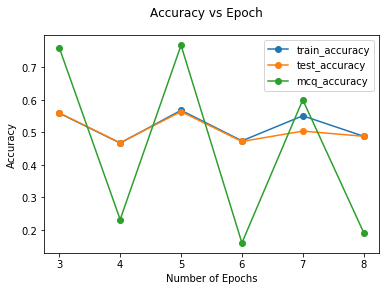

In [569]:
fig = plt.figure()
train_accuracy, = plt.plot(epoch, training_accuracy, marker = 'o')
test_accuracy, = plt.plot(epoch, testing_accuracy, marker = 'o')
mcq_accuracy, = plt.plot(epoch, mcq_accuracy, marker = 'o')
plt.legend([train_accuracy, test_accuracy, mcq_accuracy], ["train_accuracy", "test_accuracy", "mcq_accuracy"])
fig.suptitle("Accuracy vs Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.show()


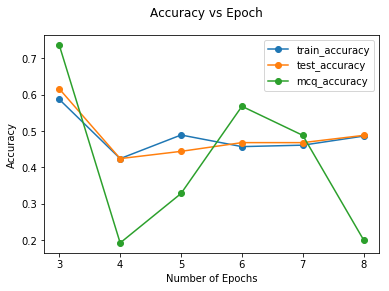

In [570]:
'''
  --max_seq_length=128 \
  --train_batch_size=32 \
  --learning_rate=2e-8 \
  --num_train_epochs= [tune]\
'''
epoch = np.array([3, 4, 5, 6, 7, 8])
training_accuracy = np.array([0.587, 0.424, 0.489, 0.457, 0.461, 0.486])
testing_accuracy = np.array([0.616, 0.424, 0.444, 0.468, 0.468, 0.488])
mcq_accuracy = np.array([0.736, 0.192, 0.328, 0.568, 0.488, 0.2])
fig = plt.figure()
train_accuracy, = plt.plot(epoch, training_accuracy, marker = 'o')
test_accuracy, = plt.plot(epoch, testing_accuracy, marker = 'o')
mcq_accuracy, = plt.plot(epoch, mcq_accuracy, marker = 'o')
plt.legend([train_accuracy, test_accuracy, mcq_accuracy], ["train_accuracy", "test_accuracy", "mcq_accuracy"])
fig.suptitle("Accuracy vs Epoch")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.show()

In [1481]:
'''BertForMultipleChoices'''
# outlook prediction resolution context
import os
def create_mcq_file(infolder, outfolder, fold_num):
    # process train
    train_file = infolder + "train.tsv"
    train_df = pd.read_csv(train_file, sep = '\t')
    assert len(train_df) == 125 * 9 * 5
    train_data = []
    for index, row in train_df.iterrows():
        if index % 5 == 0:
            resolution = row['#1 String']
            outlook0 = row['#2 String']
            outlook1 = train_df.iloc[index+1,:]['#2 String']
            outlook2 = train_df.iloc[index+2,:]['#2 String']
            outlook3 = train_df.iloc[index+3,:]['#2 String']
            outlook4 = train_df.iloc[index+4,:]['#2 String']
            train_data.append([resolution, outlook0, outlook1, outlook2, outlook3, outlook4, 0])
    # process test
    test_file = infolder + "test.tsv"
    test_df = pd.read_csv(test_file, sep = '\t')
    assert len(test_df) == 125 * 5
    test_data = []
    for index, row in test_df.iterrows():
        if index % 5 == 0:
            resolution = row['#1 String']
            outlook0 = row['#2 String']
            outlook1 = test_df.iloc[index+1,:]['#2 String']
            outlook2 = test_df.iloc[index+2,:]['#2 String']
            outlook3 = test_df.iloc[index+3,:]['#2 String']
            outlook4 = test_df.iloc[index+4,:]['#2 String']
            test_data.append([resolution, outlook0, outlook1, outlook2, outlook3, outlook4, 0])
    try:
        os.mkdir(outfolder + "fold{}".format(fold_num))
    except FileExistsError:
        pass
    train_df = pd.DataFrame(train_data, columns = ['context', 'choice0', 'choice1', 'choice2', 'choice3', 'choice4', 'label'])
    test_df = pd.DataFrame(test_data, columns = ['context', 'choice0', 'choice1', 'choice2', 'choice3', 'choice4', 'label'])
    train_df.to_csv(outfolder + "fold{}/".format(fold_num) + 'train.csv', header = True, index = False)
    train_df.to_csv(outfolder + "fold{}/".format(fold_num) + 'dev.csv', header = True, index = False)
    test_df.to_csv(outfolder + "fold{}/".format(fold_num) + 'test.csv', header = True, index = False)
    return

In [1502]:
fold_num = 10
create_mcq_file("./mcq/five_choices/fold{}/".format(fold_num),"./BertMCQ/outlook_partial/", fold_num)


In [1517]:
def create_full_file(infolder, outfolder, fold_num):
    # process train
    train_file = infolder + "train.tsv"
    train_df = pd.read_csv(train_file, sep = '\t')
    assert len(train_df) == 125 * 9 * 5
    train_data = []
    for index, row in train_df.iterrows():
        if index % 5 == 0:
            resolution = row['#1 String'] + " " + row['#3 String']
            outlook0 = row['#2 String']
            outlook1 = train_df.iloc[index+1,:]['#2 String']
            outlook2 = train_df.iloc[index+2,:]['#2 String']
            outlook3 = train_df.iloc[index+3,:]['#2 String']
            outlook4 = train_df.iloc[index+4,:]['#2 String']
            train_data.append([resolution, outlook0, outlook1, outlook2, outlook3, outlook4, 0])
    # process test
    test_file = infolder + "test.tsv"
    test_df = pd.read_csv(test_file, sep = '\t')
    assert len(test_df) == 125 * 5
    test_data = []
    for index, row in test_df.iterrows():
        if index % 5 == 0:
            resolution = row['#1 String'] + " " + row['#3 String']
            outlook0 = row['#2 String']
            outlook1 = test_df.iloc[index+1,:]['#2 String']
            outlook2 = test_df.iloc[index+2,:]['#2 String']
            outlook3 = test_df.iloc[index+3,:]['#2 String']
            outlook4 = test_df.iloc[index+4,:]['#2 String']
            test_data.append([resolution, outlook0, outlook1, outlook2, outlook3, outlook4, 0])
    try:
        os.mkdir(outfolder + "fold{}".format(fold_num))
    except FileExistsError:
        pass
    train_df = pd.DataFrame(train_data, columns = ['context', 'choice0', 'choice1', 'choice2', 'choice3', 'choice4', 'label'])
    test_df = pd.DataFrame(test_data, columns = ['context', 'choice0', 'choice1', 'choice2', 'choice3', 'choice4', 'label'])
    train_df.to_csv(outfolder + "fold{}/".format(fold_num) + 'train.csv', header = True, index = False)
    train_df.to_csv(outfolder + "fold{}/".format(fold_num) + 'dev.csv', header = True, index = False)
    test_df.to_csv(outfolder + "fold{}/".format(fold_num) + 'test.csv', header = True, index = False)
    return

In [1527]:
fold_num = 10
create_full_file("./goal_mcq_full/five_choices/fold{}/".format(fold_num),"./BertMCQ/resolution_full/", fold_num)



In [1413]:
# decide max_sequence_length by inspecting training example length
from nltk.tokenize import sent_tokenize, word_tokenize
df = pd.read_csv('final_stories.csv')
df['partial'] = df['resolution'] + df['outlook']
lengths = []
for partial in df['partial']:
    lengths.append(len(word_tokenize(partial)))

In [1418]:
from collections import Counter
print(sorted(Counter(lengths).items(), key = lambda x:x[0], reverse = True))

[(140, 1), (129, 1), (124, 1), (122, 1), (115, 1), (100, 2), (99, 1), (98, 1), (95, 1), (94, 2), (93, 1), (92, 4), (91, 1), (90, 4), (88, 2), (87, 2), (86, 2), (85, 3), (84, 3), (83, 2), (82, 4), (81, 3), (80, 5), (79, 4), (78, 4), (77, 9), (76, 7), (75, 8), (74, 8), (73, 8), (72, 11), (71, 15), (70, 14), (69, 11), (68, 9), (67, 11), (66, 13), (65, 22), (64, 19), (63, 13), (62, 9), (61, 20), (60, 20), (59, 21), (58, 21), (57, 23), (56, 31), (55, 36), (54, 20), (53, 33), (52, 24), (51, 22), (50, 27), (49, 25), (48, 24), (47, 35), (46, 31), (45, 34), (44, 24), (43, 31), (42, 32), (41, 31), (40, 36), (39, 25), (38, 22), (37, 28), (36, 23), (35, 30), (34, 29), (33, 24), (32, 13), (31, 17), (30, 19), (29, 11), (28, 14), (27, 14), (26, 19), (25, 15), (24, 26), (23, 14), (22, 15), (21, 11), (20, 10), (19, 5), (18, 6), (17, 6), (16, 3), (15, 2), (14, 2), (13, 1), (12, 2)]


In [1420]:
df['full'] = df['seed'] + df['buildup'] + df['climax'] + df['resolution'] + df['outlook']
lengths = []
for full in df['full']:
    lengths.append(len(word_tokenize(full)))

In [1421]:
print(sorted(Counter(lengths).items(), key = lambda x:x[0], reverse = True))

[(205, 1), (197, 2), (196, 1), (191, 1), (190, 1), (188, 1), (186, 1), (178, 1), (175, 1), (173, 1), (170, 3), (165, 2), (164, 2), (163, 1), (162, 1), (161, 3), (160, 3), (158, 1), (157, 2), (156, 3), (155, 7), (154, 1), (153, 8), (152, 5), (151, 4), (150, 8), (149, 6), (148, 2), (147, 8), (146, 7), (145, 7), (144, 5), (143, 6), (142, 10), (141, 10), (140, 9), (139, 8), (138, 9), (137, 6), (136, 8), (135, 16), (134, 14), (133, 21), (132, 12), (131, 17), (130, 25), (129, 17), (128, 20), (127, 13), (126, 21), (125, 23), (124, 14), (123, 21), (122, 18), (121, 26), (120, 30), (119, 27), (118, 24), (117, 21), (116, 29), (115, 16), (114, 26), (113, 27), (112, 38), (111, 27), (110, 22), (109, 20), (108, 26), (107, 24), (106, 17), (105, 23), (104, 14), (103, 27), (102, 25), (101, 19), (100, 23), (99, 25), (98, 19), (97, 19), (96, 25), (95, 21), (94, 24), (93, 17), (92, 12), (91, 12), (90, 7), (89, 13), (88, 12), (87, 13), (86, 8), (85, 9), (84, 7), (83, 5), (82, 5), (81, 11), (80, 4), (79, 3),

### Pre-training Bert ###

In [659]:
from nltk.tokenize import sent_tokenize

In [655]:
# prepare pretraining text files
df = pd.read_csv("final_stories.csv")

In [656]:
df.head()

,seed,buildup,climax,resolution,outlook
0,Amy asked her friend Jenny to go to the mall w...,Amy needed a new dress for the upcoming formal...,"One hour later, Amy still had not found a dres...","With Jenny's help, Amy finally found that dres...",Amy decided that Jenny was a friend that she c...
1,Amy asked her friend Jenny to go to the mall w...,Amy needed a new dress for the upcoming formal...,"One hour later, Amy still had not found a dres...","At the end, Amy still could not find a dress t...",Jenny thought to herself that if Amy needs a f...
2,Amy asked her friend Jenny to go to the mall w...,Amy needed a new dress for the upcoming formal...,"One hour later, Amy still had not found a dres...",Jenny told her to make up her mind soon. Amy t...,Amy was happy with Jenny's suggestion and will...
3,Amy asked her friend Jenny to go to the mall w...,Amy needed a new dress for the upcoming formal...,"One hour later, Amy still had not found a dres...",Amy relaxed and kept shopping with Jenny. It t...,Amy was glad Jenny was so patient with her and...
4,Amy asked her friend Jenny to go to the mall w...,Amy needed a new dress for the upcoming formal...,"One hour later, Amy still had not found a dres...","After taking some time to calm down, they went...",Amy was thankful to have such a good friend in...


In [696]:
stories = []
for _, row in df.iterrows():
    full_story = ' '.join([row['seed'], row['buildup'], row['climax'], row['resolution'], row['outlook']])
    #stories.append(sent_tokenize(row['resolution']) + sent_tokenize(row['outlook']))
    #stories.append([row['resolution'], row['outlook']])
    stories.append(sent_tokenize(full_story))

In [697]:
with open('all_stories.txt', 'w') as f:
    for story in stories:
        for sent in story:
            f.write(sent + '\n')
        f.write('\n')

In [1033]:
### create cv file for tuning attention weights ###
def get_fold_text(infile, test_fold):
    df = pd.read_csv(infile)
    assert len(df) == 1250
    test = list(range((test_fold - 1) * 125, test_fold * 125))
    train = list(set(range(0, 1250)) - set(test))
    train_df = df.iloc[train, :]
    assert len(train_df) == (1250 - 125)
    #test_df = df.iloc[test, :]
    '''
    with open('./attention_cv/fold{}.txt'.format(test_fold), 'w') as f:
        for _, row in train_df.iterrows():
            sents = sent_tokenize(row['resolution']) + sent_tokenize(row['outlook'])
            for sent in sents:
                f.write(sent + '\n')
            f.write('\n')
    '''
    return

In [1035]:
### create cv file for tuning attention weights ###
def get_fold_text_full(infile, test_fold):
    df = pd.read_csv(infile)
    assert len(df) == 1250
    test = list(range((test_fold - 1) * 125, test_fold * 125))
    train = list(set(range(0, 1250)) - set(test))
    train_df = df.iloc[train, :]
    assert len(train_df) == (1250 - 125)
    #test_df = df.iloc[test, :]
    with open('./attention_cv_full/fold{}.txt'.format(test_fold), 'w') as f:
        for _, row in train_df.iterrows():
            sents = sent_tokenize(row['seed']) + sent_tokenize(row['buildup']) + sent_tokenize(row['climax']) + sent_tokenize(row['resolution']) + sent_tokenize(row['outlook'])
            for sent in sents:
                f.write(sent + '\n')
            f.write('\n')
    return

In [1034]:
get_fold_text('final_stories.csv', 10)

In [1045]:
get_fold_text_full('final_stories.csv', 10)

In [ ]:
### Below for goal-oriented ie. predict resolution ###
# if the context is outlook only, 
# train it the same way as predicting outlook 
# reuse attention_cv folder

In [ ]:
# if the context is full story
# also train it the same way as predicting outlook
# reuse attention_cv_full folder
# only different at prediction time